In [1]:
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
import pickle as pkl
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
pd.set_option('display.max_columns', 500)

## Merge datasheet

In [2]:
def convert_date(date_str):
    date_format = "%Y-%m-%d"
    return datetime.strptime(str(date_str), date_format)

subject_info = pd.read_excel("Anemia variable (2018.11.16)_수정(190523).xlsx", sheet_name=0, header=0)

medication_info = pd.read_excel("Anemia variable (2018.11.16)_수정(190523).xlsx", sheet_name=1, header=0)

medication_info.columns.values[medication_info.columns.values=='순(NET)여과량'] = 'Ultrafilteration Volume'

medication_info['Study_Subject_Number'] = medication_info['Study_Subject_Number'].ffill()

medication_info['Date'] = [convert_date(val) if type(val)==str else val for val in medication_info['Date'].values]

data = pd.merge(subject_info, medication_info, left_on='Subject No.', right_on='Study_Subject_Number', how='outer')

# EPO = darne + 4/3*epoetin + 1/200*erythropietin 
data['EPO_Dose'] = data['Dose_Darbepoetin-alpha'] + 4/3*data['Dose_Epoetin-beta'] + 1/200*(data['Dose_Erythropoietin-alpha'] + data['Dose_Erythropoietin-alpha.1'])

data = pd.concat([data, pd.get_dummies(data['Sex'], prefix='Sex')], axis=1)

data = data[data['Transfusion']==0]

data = data[np.invert(data['Study_Subject_Number'].isnull())]

# Remove C 
group = []
for i, c in enumerate(data['Study_Subject_Number']):
    try:
        group.append(re.sub('[-0-9]', '',c))
    except:
        print(i)
group = np.array(group)
data = data[group!='C']

# Remove NAs in Height 
for p in np.unique(data['Study_Subject_Number'][np.isnan(data['Height (cm)'].values)]):
    data = data[data['Study_Subject_Number']!=p]

# EPO Adjustment
indexes = np.unique(data['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [data['Study_Subject_Number'].values[index] for index in sorted(indexes)]
for p in patient_list:
    data['EPO_Dose'][data['Study_Subject_Number']==p] = np.array(data['EPO_Dose'][data['Study_Subject_Number']==p][1:].values.tolist() + [0.0])

data = data[['Study_Subject_Number', 'Order', 
             'Age (yrs)', 'Sex_M', 'Sex_F', 'Height (cm)',
           'Date',
           'SBP_start(mmHg)', 'SBP_End(mmHg)', 'Dry Weight',
           'Predialysis Weight',
           'Post_dialysis Weight',
           'Ultrafilteration Volume',
           'Hct[Whole blood]', 'MCV[Whole blood]', 'MCHC[Whole blood]',
           'MCH[Whole blood]', 'RDW[Whole blood]', 'MPV[Whole blood]',
           'PLT Count[Whole blood]', 'WBC COUNT[Whole blood]',
           'Calcium[Serum]', 'Inorganic P[Serum]', 'Glucose[Serum]',
           'Total Protein[Serum]', 'Albumin[Serum]', 'Creatinine[Serum]',
           'Uric Acid[Serum]', 'Serum Iron[Serum]', 'URR[Serum]',
           'EPO_Dose', 'Hemoglobin[Whole blood]']]  

data.to_excel('merged_data.xlsx', index=False)

C:\Users\GB\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Preprocess

In [3]:
df = pd.read_excel("merged_data.xlsx", sheet_name=0, header=0)

In [4]:
df.isnull().sum()

Study_Subject_Number          0
Order                         0
Age (yrs)                     0
Sex_M                         0
Sex_F                         0
Height (cm)                   0
Date                          0
SBP_start(mmHg)               0
SBP_End(mmHg)               212
Dry Weight                   60
Predialysis Weight            9
Post_dialysis Weight        113
Ultrafilteration Volume       8
Hct[Whole blood]              3
MCV[Whole blood]            190
MCHC[Whole blood]           190
MCH[Whole blood]            190
RDW[Whole blood]             71
MPV[Whole blood]            172
PLT Count[Whole blood]      142
WBC COUNT[Whole blood]        3
Calcium[Serum]               81
Inorganic P[Serum]           92
Glucose[Serum]              106
Total Protein[Serum]         70
Albumin[Serum]               63
Creatinine[Serum]            53
Uric Acid[Serum]            111
Serum Iron[Serum]          5445
URR[Serum]                 3021
EPO_Dose                      0
Hemoglob

In [5]:
len(df)

20165

# Variable Preprocessing

In [6]:
indexes = np.unique(df['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [df['Study_Subject_Number'].values[index] for index in sorted(indexes)]
len(patient_list)

592

In [7]:
info_vars = ['Study_Subject_Number', 'Order'] 

categoryA = ["Hemoglobin[Whole blood]", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars

In [8]:
len(all_vars)

17

In [9]:
target_hb = []
delta_hb = []
date_diff = []
for p in patient_list:
    temp = df[df['Study_Subject_Number']==p]
    target_hb.extend(temp["Hemoglobin[Whole blood]"].values[1:].tolist()+[np.nan])
    delta_hb.extend([np.nan]+np.abs(temp["Hemoglobin[Whole blood]"].values[:-1]-temp["Hemoglobin[Whole blood]"].values[1:]).tolist())
    date_diff.extend((pd.to_datetime(temp["Date"][1:].values) -  pd.to_datetime(temp["Date"][:-1].values)).days.tolist()+[np.nan])

df['Date_diff'] = date_diff
df['Target_Hb'] = target_hb
df['Delta_Hb'] = delta_hb

df.drop(df[df['Target_Hb'].isna()].index, axis=0, inplace=True)
df.drop(df[df['Delta_Hb'].isna()].index, axis=0, inplace=True)
df.index = list(range(len(df)))

# 'Hemoglobin[Whole blood]'

In [10]:
var = trn_vars[0]
var

'Hemoglobin[Whole blood]'

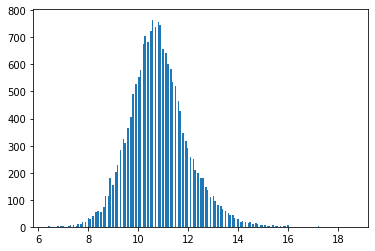

[ 6.4  8.   8.2  9.4 10.1 10.7 11.5 12.9 14.  14.6 18.6]


In [11]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [12]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:10])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-10:])

[6.4 6.4 6.8 6.8 6.9 6.9 6.9 6.9 7.  7. ]
[16.  16.  16.6 17.  17.2 17.2 17.7 17.9 18.1 18.6]


In [13]:
df['Study_Subject_Number'][df[var] > 16] 

3633    E-091
3634    E-091
3635    E-091
3636    E-091
3637    E-091
3638    E-091
3639    E-091
3640    E-091
Name: Study_Subject_Number, dtype: object

In [14]:
df = df[df['Study_Subject_Number']!='E-091']

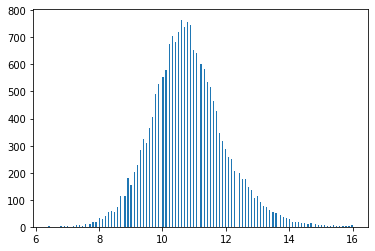

[ 6.4  8.   8.2  9.4 10.1 10.7 11.5 12.9 14.  14.5 16. ]


In [15]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [16]:
df['Study_Subject_Number'][df[var] <= 6.5] 

2460     E-015
16836    A-064
Name: Study_Subject_Number, dtype: object

In [17]:
df[var][df[var] <= 6.5] 

2460     6.4
16836    6.4
Name: Hemoglobin[Whole blood], dtype: float64

In [18]:
for p in df['Study_Subject_Number'][df[var] <= 6.5].values:
    df = df[df['Study_Subject_Number']!=p]

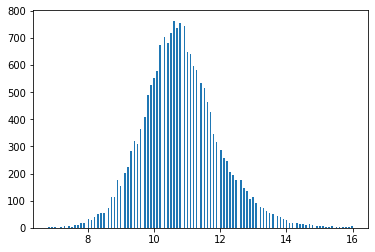

[ 6.8    8.     8.3    9.4   10.1   10.7   11.5   12.895 14.    14.5
 16.   ]


In [19]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

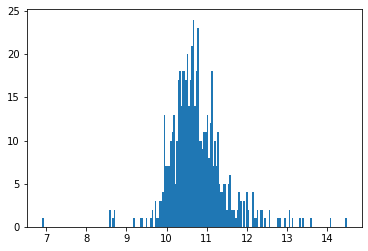

In [20]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [21]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() < 8]

Study_Subject_Number
F-063    6.9
Name: Hemoglobin[Whole blood], dtype: float64

In [22]:
df = df[df['Study_Subject_Number']!='F-063']

In [23]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() > 13.5]

Study_Subject_Number
B-081    13.578571
G-090    14.486667
G-200    14.100000
Name: Hemoglobin[Whole blood], dtype: float64

In [24]:
df = df[df['Study_Subject_Number']!='G-090']
df = df[df['Study_Subject_Number']!='G-200']

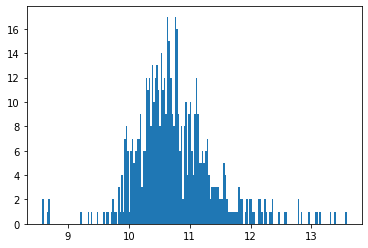

In [25]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [26]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() < 9]

Study_Subject_Number
A-146    8.600
A-167    8.575
D-124    8.700
E-024    8.700
H-002    8.675
Name: Hemoglobin[Whole blood], dtype: float64

C:\Users\GB\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\GB\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


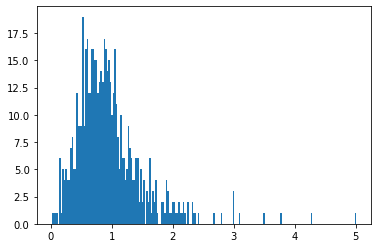

In [27]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [28]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 2.5]

Study_Subject_Number
A-013    3.503000
A-111    2.992889
A-156    3.010000
A-172    3.105000
E-007    4.270000
E-023    5.004889
F-098    2.795000
G-030    2.674667
G-031    3.765880
H-014    3.008517
Name: Hemoglobin[Whole blood], dtype: float64

In [29]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 2.5].index.values:
    df = df[df['Study_Subject_Number']!=p]

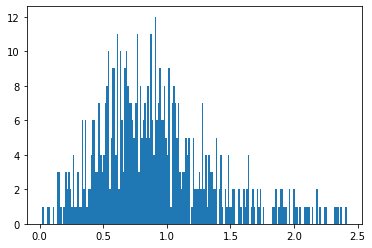

In [30]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

# EPO DOSE

In [31]:
var = trn_vars[9]
var

'EPO_Dose'

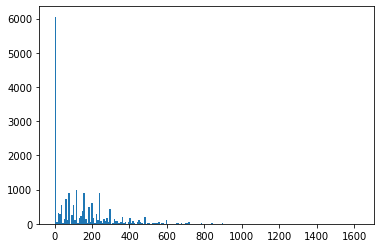

[   0.    0.    0.    0.    0.   90.  200.  450.  680.  750. 1625.]


In [32]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [33]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:10])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-10:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1080. 1080. 1080. 1080. 1080. 1080. 1120. 1200. 1260. 1625.]


In [34]:
len(df['Study_Subject_Number'][df[var] >= 800])

73

In [35]:
for p in df['Study_Subject_Number'][df[var] >= 800].values:
    df = df[df['Study_Subject_Number']!=p]

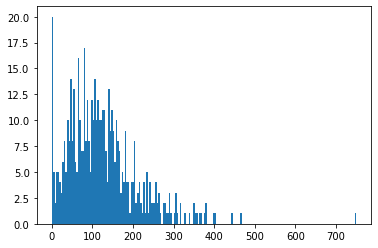

In [36]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [37]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() > 500]

Study_Subject_Number
A-018    750.0
Name: EPO_Dose, dtype: float64

In [38]:
df = df[df['Study_Subject_Number']!='A-018']

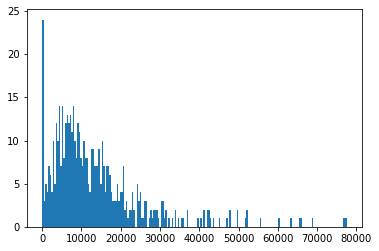

In [39]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [40]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 39000]

Study_Subject_Number
A-005    51680.000000
A-037    60247.619048
A-038    77500.000000
A-041    68830.000000
A-043    77091.666667
A-045    41125.831821
A-092    41946.606335
A-100    47112.380952
A-128    44951.515152
B-014    55440.418935
F-022    42390.151515
F-036    47857.142857
F-079    63176.666667
G-018    41358.333333
G-042    52006.593407
G-050    40372.300363
G-061    49610.738052
G-065    49819.444444
G-068    42636.000000
G-078    39654.285714
G-093    65849.090909
G-106    42136.453202
G-139    47958.371878
G-197    42287.719298
G-209    43412.380952
G-253    65877.777778
G-273    52269.444444
Name: EPO_Dose, dtype: float64

# 'RDW[Whole blood]'

In [41]:
var = trn_vars[1]
var

'RDW[Whole blood]'

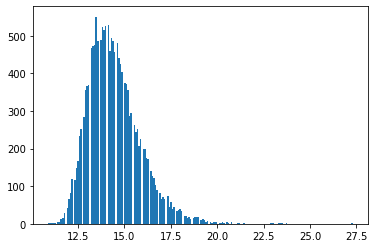

[10.9 11.9 12.  12.9 13.5 14.3 15.2 17.  18.7 19.2 27.3]


In [42]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [43]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:10])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-10:])

[10.9 11.  11.1 11.1 11.2 11.2 11.3 11.3 11.4 11.4]
[21.4 21.4 22.9 22.9 23.  23.3 23.4 23.5 23.7 27.3]


In [44]:
df[var][df[var] >= 25]

1608    27.3
Name: RDW[Whole blood], dtype: float64

In [45]:
df['Study_Subject_Number'][df[var] >= 25]

1608    D-088
Name: Study_Subject_Number, dtype: object

In [46]:
df = df[df['Study_Subject_Number']!='D-088']

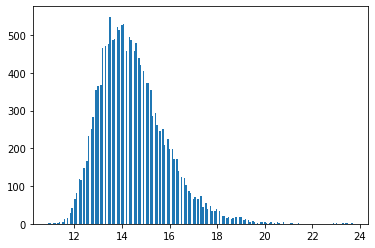

[10.9 11.9 12.  12.9 13.5 14.3 15.2 17.  18.7 19.2 23.7]


In [47]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

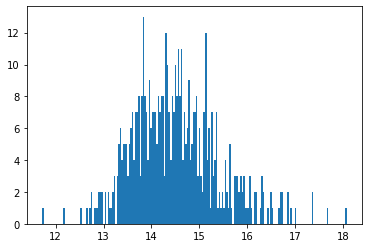

In [48]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

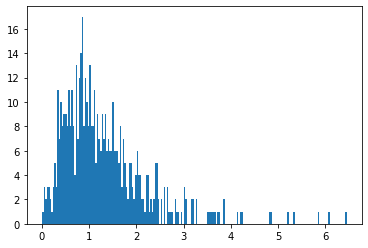

In [49]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [50]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 4.5]

Study_Subject_Number
A-005    6.077000
A-090    5.199000
B-040    4.857571
E-026    4.828000
E-067    5.855076
F-043    5.340721
H-022    6.448000
Name: RDW[Whole blood], dtype: float64

In [51]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 4.5].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'MCV[Whole blood]'

In [52]:
var = trn_vars[2]
var

'MCV[Whole blood]'

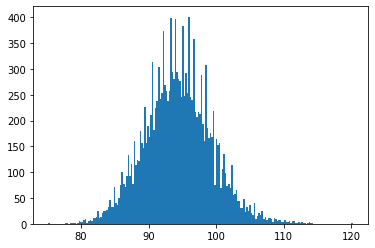

[ 75.2  82.1  83.2  88.1  91.1  94.3  97.6 102.5 107.2 109.  120.2]


In [53]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [54]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:30])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-30:])

[75.2 77.8 77.9 78.5 78.6 78.9 79.2 79.2 79.5 79.8 79.8 79.8 79.9 79.9
 80.  80.  80.1 80.3 80.3 80.3 80.4 80.4 80.4 80.4 80.5 80.5 80.5 80.6
 80.7 80.7]
[111.4 111.5 111.5 111.5 111.6 111.6 111.6 111.7 111.9 111.9 112.1 112.2
 112.3 112.4 112.6 112.6 112.6 112.8 112.9 113.  113.  113.5 113.8 113.8
 113.8 114.  114.1 114.2 114.2 120.2]


In [55]:
df['Study_Subject_Number'][df[var] > 120]

8716    H-008
Name: Study_Subject_Number, dtype: object

In [56]:
df = df[df['Study_Subject_Number']!='H-008']

In [57]:
df['Study_Subject_Number'][df[var] < 76]

18785    A-187
Name: Study_Subject_Number, dtype: object

In [58]:
df = df[df['Study_Subject_Number']!='A-187']

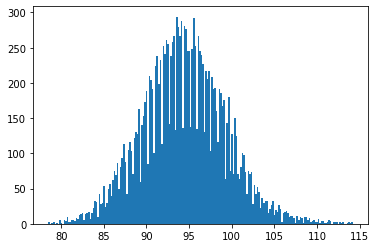

[ 78.5     82.3     83.4     88.2     91.1     94.3     97.6    102.5
 106.9    108.8005 114.2   ]


In [59]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

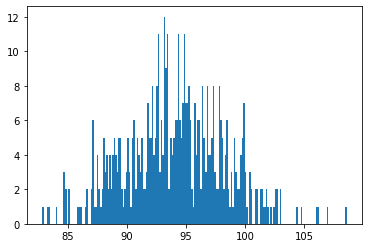

In [60]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

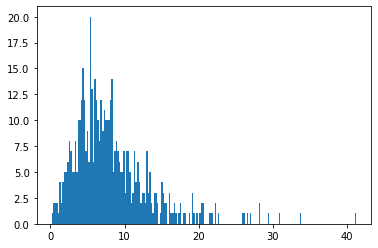

In [61]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [62]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 25]

Study_Subject_Number
A-055    26.923000
B-069    25.991286
B-080    33.753064
D-032    26.515000
D-049    29.549686
D-058    30.888000
D-082    28.249167
E-083    28.119280
G-068    26.107500
H-032    41.258000
Name: MCV[Whole blood], dtype: float64

In [63]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 25].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'MCH[Whole blood]'

In [64]:
var = trn_vars[3]
var

'MCH[Whole blood]'

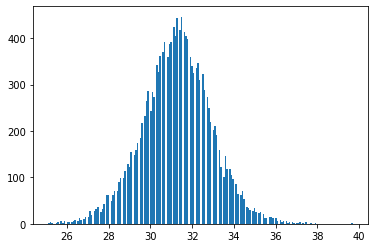

[25.1   26.8   27.253 29.2   30.2   31.3   32.3   34.    35.3   35.9
 39.7  ]


In [65]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [66]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:10])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-10:])

[25.1 25.1 25.2 25.2 25.2 25.3 25.5 25.6 25.6 25.6]
[37.2 37.3 37.3 37.5 37.5 37.5 37.5 37.7 37.9 39.7]


In [67]:
df['Study_Subject_Number'][df[var] > 38]

6370    F-010
Name: Study_Subject_Number, dtype: object

In [68]:
df = df[df['Study_Subject_Number']!='F-010']

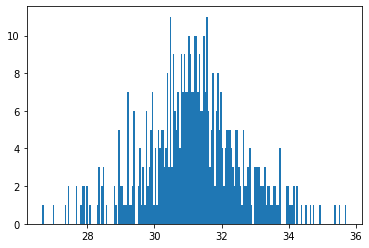

In [69]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

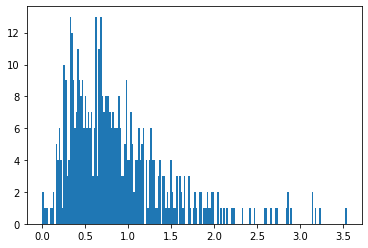

In [70]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [71]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 3.0]

Study_Subject_Number
A-097    3.231981
A-121    3.142016
D-033    3.544570
E-001    3.151238
F-022    3.182652
Name: MCH[Whole blood], dtype: float64

In [72]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 3.0].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'MCHC[Whole blood]'

In [73]:
var = trn_vars[4]
var

'MCHC[Whole blood]'

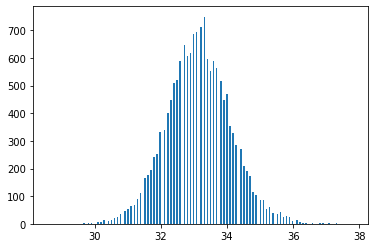

[28.6 30.6 30.9 31.9 32.5 33.1 33.8 34.7 35.6 35.9 37.8]


In [74]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [75]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:10])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-10:])

[28.6 29.5 29.7 29.7 29.8 29.8 29.8 29.8 29.9 29.9]
[36.9 37.  37.1 37.1 37.3 37.3 37.3 37.4 37.5 37.8]


In [76]:
df['Study_Subject_Number'][df[var] < 29]

4770    B-043
Name: Study_Subject_Number, dtype: object

In [77]:
df = df[df['Study_Subject_Number']!='B-043']

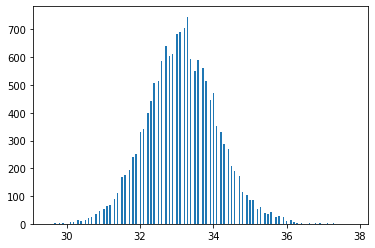

[29.5 30.6 30.9 31.9 32.5 33.1 33.8 34.7 35.6 35.9 37.8]


In [78]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

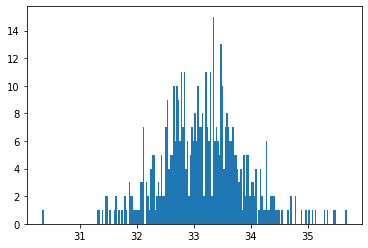

In [79]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [80]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() < 31]

Study_Subject_Number
E-037    30.335294
Name: MCHC[Whole blood], dtype: float64

In [81]:
df = df[df['Study_Subject_Number']!='E-037']

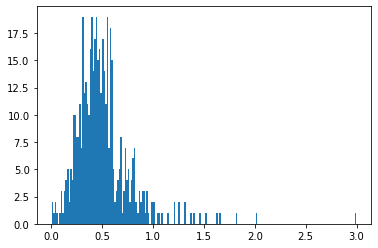

In [82]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [83]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 2.5]

Study_Subject_Number
D-009    2.99619
Name: MCHC[Whole blood], dtype: float64

In [84]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 2.5].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'Serum Iron[Serum]'

In [85]:
var = trn_vars[5]
var

'Serum Iron[Serum]'

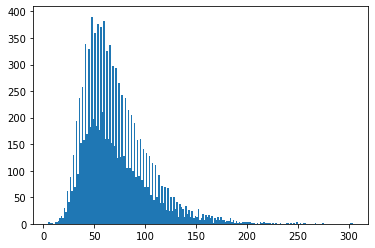

[  5.    20.    23.    37.    48.    65.    88.   132.   176.   195.34
 304.  ]


In [86]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [87]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:30])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-30:])

[ 5.  5.  5.  5.  7.  7.  9. 11. 11. 12. 13. 13. 13. 13. 14. 14. 14. 14.
 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.]
[217. 217. 217. 218. 220. 220. 221. 223. 223. 225. 225. 228. 229. 233.
 233. 239. 241. 243. 244. 246. 249. 249. 250. 253. 255. 257. 267. 275.
 302. 304.]


In [88]:
df['Study_Subject_Number'][df[var] < 12]

2447     E-011
5128     B-052
8656     F-106
16689    A-051
16786    A-061
17851    A-125
17927    A-128
17956    A-133
18545    A-167
Name: Study_Subject_Number, dtype: object

In [89]:
df['Study_Subject_Number'][df[var] > 300]

4094     B-009
16798    A-063
Name: Study_Subject_Number, dtype: object

In [90]:
for p in df['Study_Subject_Number'][df[var] > 300].values:
    df = df[df['Study_Subject_Number']!=p]

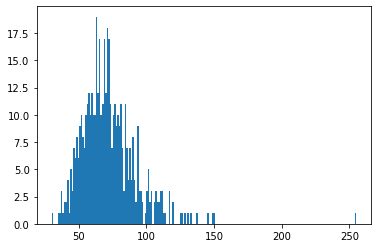

In [91]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [92]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() > 200]

Study_Subject_Number
G-018    255.0
Name: Serum Iron[Serum], dtype: float64

In [93]:
for p in df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() > 200].index.values:
    df = df[df['Study_Subject_Number']!=p]

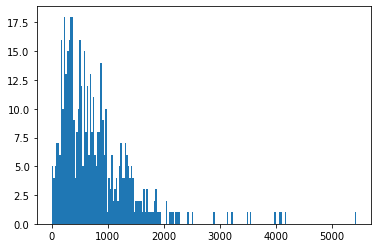

In [94]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [95]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 2500]

Study_Subject_Number
A-074    2887.928571
A-102    4182.166667
A-136    4081.290909
A-193    3137.767196
A-194    3496.696429
D-116    3993.923077
E-002    4071.200000
F-045    3544.590090
G-093    5434.666667
G-166    3224.200000
G-265    2517.666667
Name: Serum Iron[Serum], dtype: float64

In [96]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 2500].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'URR[Serum]'

In [97]:
var = trn_vars[10]
var

'URR[Serum]'

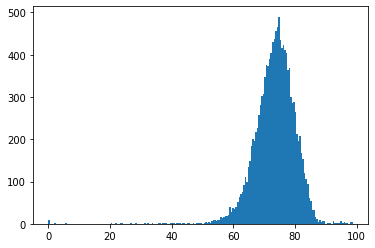

[ 0.         52.96735    56.4664     65.81464473 69.85       73.93719708
 77.66437733 82.7285     85.91709776 88.13187434 98.7       ]


In [98]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [99]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:30])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-30:])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          2.06422018  5.55       20.51282051 21.92982456
 23.4        23.96313364 26.77824268 28.57       31.2335958  32.15
 33.95522388 35.55       35.69       36.12334802 36.5        37.33905579
 37.65060241 37.87878788 38.02281369 39.50617284 40.03       40.69      ]
[93.62041467 93.75       93.98797595 94.02985075 94.46564885 94.57364341
 94.90909091 94.92600423 94.95       95.02369668 95.14563107 95.22968198
 95.62043796 95.68627451 95.76399395 96.02356406 96.19377163 96.23
 96.54       96.62       96.91       97.18       97.85330948 98.03
 98.09       98.11       98.28       98.44       98.65       98.7       ]


In [100]:
df['URR[Serum]'][df['URR[Serum]']<40] = None

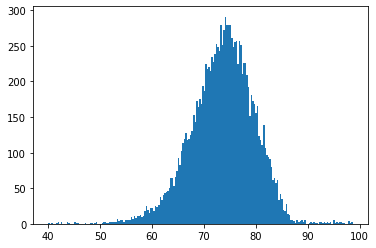

[40.03       54.74150439 57.29841361 65.88617812 69.88371565 73.9489479
 77.6822779  82.7356389  85.91974097 88.13640871 98.7       ]


In [101]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

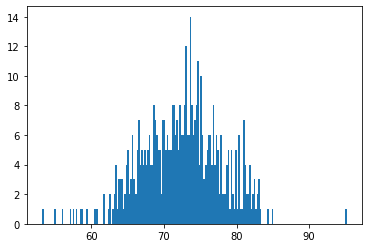

In [102]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [103]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() > 90]

Study_Subject_Number
B-016    95.156996
Name: URR[Serum], dtype: float64

In [104]:
df = df[df['Study_Subject_Number']!='B-016']

In [105]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() < 60]

Study_Subject_Number
A-201    56.151760
B-021    59.366579
E-004    57.526000
E-006    58.525000
E-065    54.917000
F-079    57.088123
F-080    53.229167
F-106    57.895012
H-009    58.800000
Name: URR[Serum], dtype: float64

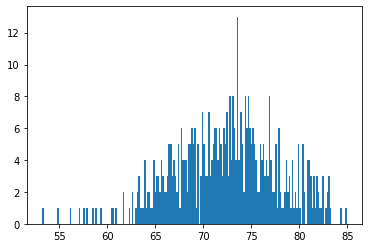

In [106]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

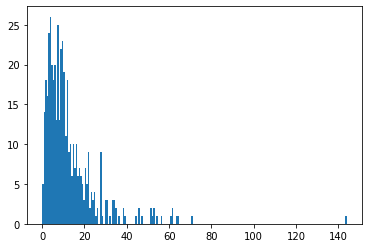

In [107]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [108]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 80]

Study_Subject_Number
A-201    143.86392
Name: URR[Serum], dtype: float64

In [109]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 80].index.values:
    df = df[df['Study_Subject_Number']!=p]

# Dry Weight

In [110]:
var = trn_vars[11]
var

'Dry Weight'

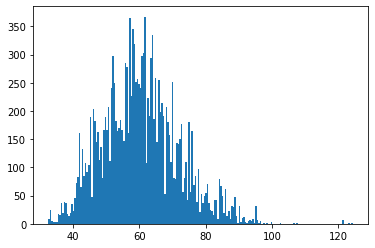

[ 32.7     36.2445  37.5     46.      52.3     60.      67.4     81.
  89.211   93.6665 124.3   ]


In [111]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [112]:
df['Study_Subject_Number'][df[var] > 100]

2427    E-006
2428    E-006
2429    E-006
4272    B-021
4273    B-021
4274    B-021
4275    B-021
4276    B-021
4277    B-021
4278    B-021
4279    B-021
8095    F-080
Name: Study_Subject_Number, dtype: object

In [113]:
df = df[df['Study_Subject_Number']!='B-021']

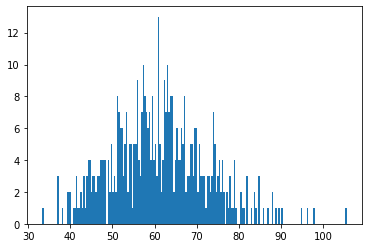

In [114]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

In [115]:
df.groupby('Study_Subject_Number')[var].mean()[df.groupby('Study_Subject_Number')[var].mean() > 100]

Study_Subject_Number
E-006    105.5
Name: Dry Weight, dtype: float64

In [116]:
df = df[df['Study_Subject_Number']!='E-006']

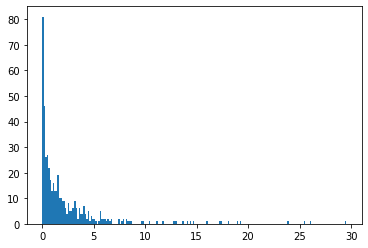

In [117]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [118]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 20]

Study_Subject_Number
A-085    26.074323
A-122    29.547143
F-067    25.468875
G-105    23.927005
Name: Dry Weight, dtype: float64

In [119]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 20].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'Albumin[Serum]'

In [120]:
var = trn_vars[12]
var

'Albumin[Serum]'

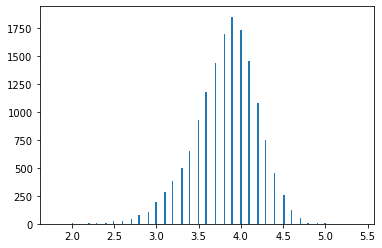

[1.8 2.7 2.8 3.3 3.6 3.9 4.1 4.4 4.6 4.6 5.4]


In [121]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

In [122]:
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[:30])
print(np.sort(df[var].values[np.invert(np.isnan(df[var].values))])[-30:])

[1.8 1.9 2.  2.  2.  2.1 2.1 2.2 2.2 2.2 2.2 2.2 2.2 2.2 2.3 2.3 2.3 2.4
 2.4 2.4 2.4 2.4 2.4 2.4 2.5 2.5 2.5 2.5 2.5 2.5]
[4.7 4.7 4.7 4.7 4.7 4.7 4.7 4.7 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8
 4.9 4.9 4.9 4.9 4.9 4.9 4.9 5.  5.  5.  5.1 5.4]


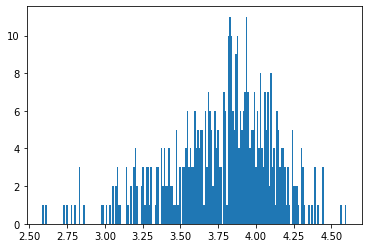

In [123]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

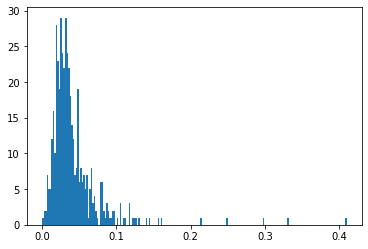

In [124]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [125]:
df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 0.2]

Study_Subject_Number
A-146    0.410000
B-001    0.331821
D-112    0.249753
F-078    0.298022
F-079    0.213667
Name: Albumin[Serum], dtype: float64

In [126]:
for p in df.groupby('Study_Subject_Number')[var].var()[df.groupby('Study_Subject_Number')[var].var() > 0.2].index.values:
    df = df[df['Study_Subject_Number']!=p]

# 'Predialysis Weight'

In [127]:
var = trn_vars[13]
var

'Predialysis Weight'

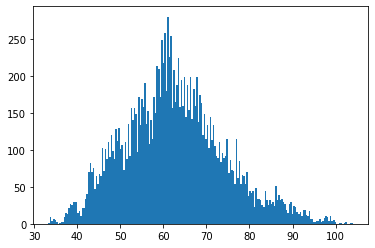

[ 33.3      37.95125  39.       47.7      54.5125   61.8      69.6375
  84.3      92.795    95.8     104.     ]


In [128]:
plt.hist(df[var].values, bins=200)
plt.show()
print(np.percentile(df[var].values[np.invert(np.isnan(df[var].values))], q=[0, 0.5, 1, 10, 25,50,75,95,99,99.5,100]))

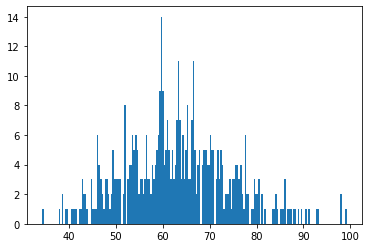

In [129]:
plt.hist(df.groupby('Study_Subject_Number')[var].mean(), bins=200)
plt.show()

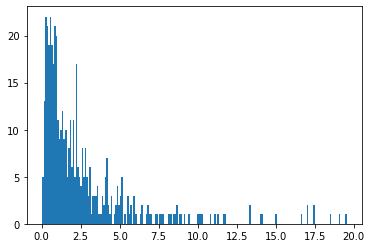

In [130]:
plt.hist(df.groupby('Study_Subject_Number')[var].var(), bins=200)
plt.show()

In [131]:
df.to_excel('data_processed.xlsx', index=False)